# About
- Main Aim of this project is to build a NLP model so that it can label Abstract of a medical research paper.
- The paper that we are replicating the source of dataset that we will be using is available here : https://arxiv.org/abs/1710.06071
- Reading paper we see the model architecture that they use to achieve best score is available here https://arxiv.org/abs/1612.05251

#Installing and upgrading dependencies

In [1]:
!pip install --upgrade tensorflow tensorflow-hub

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Embedding, Input, Bidirectional, LSTM, Dropout, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint

# Checking Access To GPU
- (as we are building deep learning model)

In [3]:
!nvidia-smi

Sun Aug 13 10:56:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8c004deb-88ab-dbad-6e95-a0960c332f6c)


In [5]:
# so we can see we are usig Tesla T4 gpu provided by google thatnks to them!!

# Getting Data
- Dataset has been made publicly available here : https://github.com/Franck-Dernoncourt/pubmed-rct

In [6]:
# cloning files from github
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [7]:
# Checking out files in pubmed-rct
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [8]:
# Pubmed_20k_RCT is subset of 200k dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [9]:
!ls /content/pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


- Start out experiment with 20k dataset with numbers replace by @ sign
- Reason for number replace by @ sign In some cases, tokenizers replace numbers with special symbols like "@" or "#NUMBER" to standardize numerical information. This preprocessing step aims to prevent the model from overfitting on specific numeric values and helps to generalize the data better. Additionally, it reduces the vocabulary size and makes it easier for models to handle numerical information in a consistent way.



In [10]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [11]:
import os

In [12]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [13]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocessing Data
- As we can see that text files are not in format that we can use directly
- So we need to preprocess it

In [14]:
def get_lines(filename):
  """
  Function to read sentences in a file
  Agrs:
    filename: path to the file
  Returns:
    A list of string with one string per line from the target file
  """
  with open(filename, "r") as file:
    return file.readlines()

In [15]:
train_lines = get_lines(data_dir + "train.txt")

In [16]:
train_lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [17]:
len(train_lines)

210040

- Let's think about how we want our data to look
- How our data should look like :

```
[{
  "line_number" : 0,
  "target" : "BACKGROUND,
  "text" : "What u doing?",
  "total_lines" : 11,}
  ...]
```
**Note** : We are required line_number and total_lines in an abstract so that we can do positional embedding (feature engineering) will use in model 5 later

In [18]:
def process_abstract_lines(abstract_lines):
  abstract_lines_split = abstract_lines.splitlines()
  abstract_samples = []
  for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
    line_data = {}
    target_text_split = abstract_line.split("\t")
    line_data["target"] = target_text_split[0]
    line_data["text"] = target_text_split[1].lower()
    line_data["line_number"] = abstract_line_number
    line_data["total_lines"] = len(abstract_lines_split) -1
    abstract_samples.append(line_data)
  return abstract_samples

In [19]:
def preprocess_file(filename):
  """
  Takes a filepath read that file
  Agrs:
    filename = filepaht
  Returns:
    Return a list of abstrcts line in dictionary format
  """
  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith("###"): # check to see if this line is an ID line
      abstract_id = line
      abstract_lines = "" # resetting abstract to empty string
    elif line.isspace(): # check to see if it is end of abstract as we can see from the text file above
      # This is one particular abstract we are dealing with it
      abstract_samples  += process_abstract_lines(abstract_lines)
    else:
      abstract_lines += line # else it is a line from abstract
  return abstract_samples

In [20]:
train_samples = preprocess_file(data_dir + "train.txt")
val_samples = preprocess_file(data_dir + "dev.txt")
test_samples = preprocess_file(data_dir + "test.txt")

In [21]:
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [22]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

# Let's Visualize This Data In DataFrame
- This is one of profit of converting data into dictinoary format

In [23]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [24]:
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [25]:
val_df.head(12)

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9
5,RESULTS,sixty-five patients were randomized .,5,9
6,RESULTS,fifty-nine patients started treatment ( @ rece...,6,9
7,RESULTS,fifty-six patients took the full @ months of m...,7,9
8,RESULTS,"between the voriconazole and placebo groups , ...",8,9
9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9,9


In [26]:
test_df.head(12)

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8
6,RESULTS,multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12


In [27]:
# lets' check out distibution of labels

In [28]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Different Target Categories')

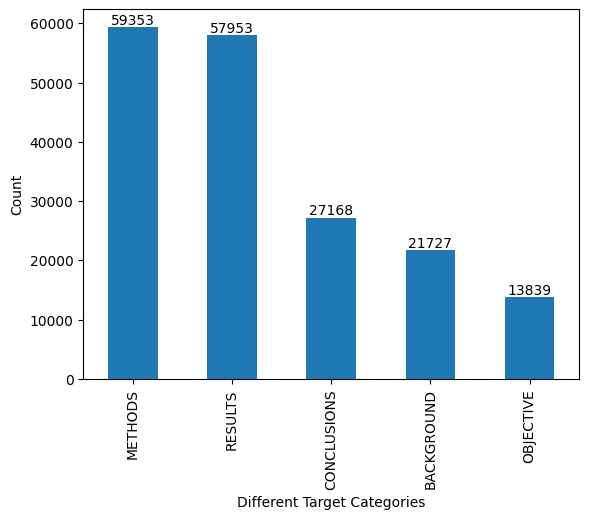

In [29]:
ax = train_df["target"].value_counts().plot(kind="bar")
plt.ylabel("Count")
for index, value in enumerate(train_df["target"].value_counts()):
  ax.text(index, value, str(value), ha='center', va='bottom')
plt.xlabel("Different Target Categories")

In [30]:
# Lets check lenth of different lines

Text(0.5, 0, 'Number Of Sentence Per Abstract')

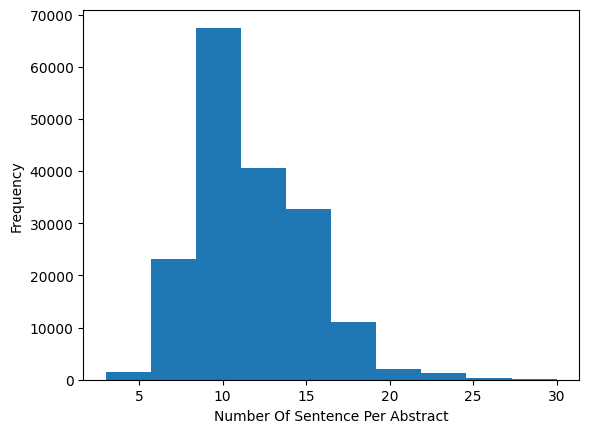

In [31]:
train_df["total_lines"].plot(kind="hist")
plt.xlabel("Number Of Sentence Per Abstract")

# Get List Of Sentences

In [32]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [33]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make Numerica Labels for target
- as model require numerical labels

## One Hot Encoding

In [34]:
from sklearn.preprocessing import OneHotEncoder

In [35]:
one_hot_enocoder = OneHotEncoder()

In [36]:
train_labels_one_hot = one_hot_enocoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1)).toarray()

In [37]:
val_labels_one_hot = one_hot_enocoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1)).toarray()

In [38]:
test_labels_one_hot = one_hot_enocoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1)).toarray()

In [39]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Integer Labels

In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
label_encoder = LabelEncoder()

In [42]:
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())

In [43]:
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())

In [44]:
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

In [45]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [46]:
# Get class names

In [47]:
num_classes = len(label_encoder.classes_)

In [48]:
class_names = label_encoder.classes_

In [49]:
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Models We Are Going To Try
1. Naive Bayes with TF-IDF encoder (baseline)
2. Conv1D with token embeddings.
3. Tensorflow hub feature extractor.
4. Conv1D with character embedding.
5. Pretrained token embedding + character embedding
6. Pretrained token embedding + character embedding + positional embeddings

# Model Evaluation Function

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(y_true, y_pred, model_name):
  report = classification_report(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)
  print(report)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=2, xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title(f"Confusion Matrix For : {model_name}")
  plt.savefig(f"/content/drive/MyDrive/Skimlit Project/evaluation_confusion_matrix/{model_name}.png", bbox_inches="tight")


# Connecting To Google Drive

In [51]:
from google.colab import drive

In [52]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Model 0 (Naive Bayes with TF-IDF Baseline)

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [54]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

In [55]:
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [56]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [57]:
model_0_pred = model_0.predict(val_sentences)

              precision    recall  f1-score   support

           0       0.66      0.49      0.56      3449
           1       0.65      0.59      0.61      4582
           2       0.72      0.87      0.79      9964
           3       0.75      0.14      0.23      2376
           4       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



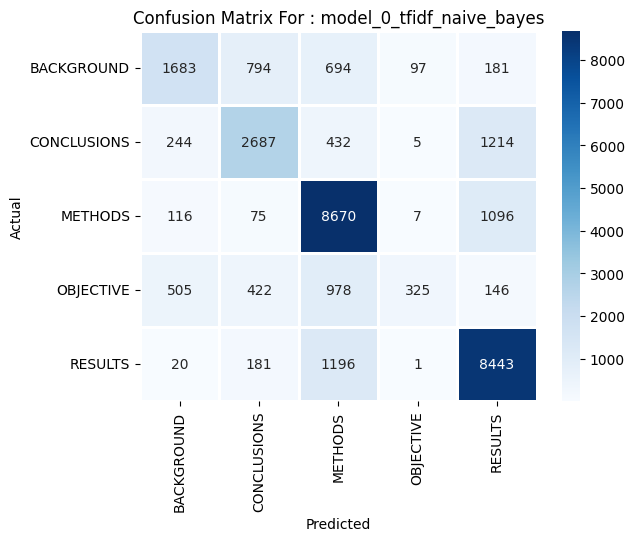

In [58]:
evaluate_model(val_labels_encoded, model_0_pred, "model_0_tfidf_naive_bayes")

# Peparing Data For Deep Sequence Models

## Finding what should be output sequence lenght and size of vocabulary

In [59]:
sen_len = [len(sentence.split()) for sentence in train_sentences]

In [60]:
sen_len_avg = np.mean(sen_len)

In [61]:
sen_len_avg

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

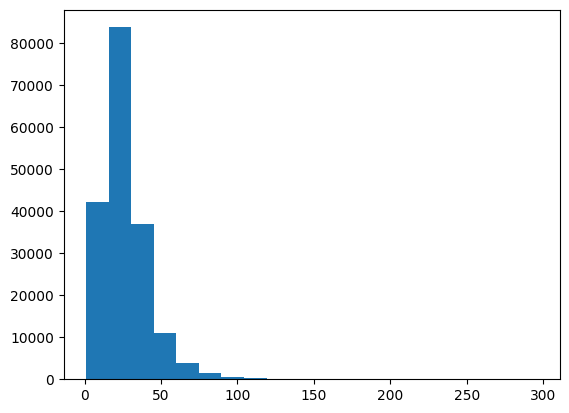

In [62]:
plt.hist(sen_len, bins=20)

In [63]:
output_seq_len = int(np.percentile(sen_len, 95))

In [64]:
output_seq_len

55

In [65]:
max(sen_len)

296

In [66]:
max_tokens = 68000 # From paper

## TextVectorization

In [67]:
from tensorflow.keras.layers import TextVectorization, Embedding

In [68]:
text_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_sequence_length=output_seq_len,
    pad_to_max_tokens=True,
)

In [69]:
text_vectorizer.adapt(train_sentences)

In [70]:
text_vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'of',
 'in',
 'to',
 'with',
 'a',
 'were',
 'was',
 'for',
 'patients',
 'group',
 'p',
 'at',
 'or',
 'study',
 'on',
 'treatment',
 'is',
 'after',
 'by',
 'this',
 'groups',
 'as',
 'an',
 'from',
 'that',
 'randomized',
 'between',
 'not',
 'trial',
 'no',
 'compared',
 'control',
 'be',
 'significant',
 'intervention',
 'significantly',
 'n',
 'months',
 'than',
 'we',
 'vs',
 'rsb',
 'lsb',
 'clinical',
 'placebo',
 'baseline',
 'ci',
 'two',
 'during',
 'weeks',
 'both',
 'had',
 'primary',
 'mean',
 'are',
 'using',
 'participants',
 'there',
 'all',
 'time',
 'years',
 'pain',
 'therapy',
 'who',
 'mg',
 'more',
 'effect',
 'effects',
 'but',
 'risk',
 'difference',
 'outcomes',
 'total',
 'care',
 'rate',
 'efficacy',
 'received',
 'associated',
 'higher',
 'respectively',
 'days',
 'analysis',
 'outcome',
 'use',
 'one',
 'week',
 'women',
 'may',
 'randomly',
 'levels',
 'followup',
 'will',
 'increased',
 'health',
 'used',
 'have',
 'data'

In [71]:
train_text_vectorized = text_vectorizer(train_sentences)

In [72]:
train_text_vectorized

<tf.Tensor: shape=(180040, 55), dtype=int64, numpy=
array([[   6,  331,    2, ...,    0,    0,    0],
       [   8,   76,    4, ...,    0,    0,    0],
       [  86,  213,  121, ...,    0,    0,    0],
       ...,
       [  54,  667,   55, ...,    0,    0,    0],
       [  34,    7,  165, ...,    0,    0,    0],
       [1072,  388,    7, ...,    0,    0,    0]])>

In [73]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Embedding

In [74]:
embedding = Embedding(
    input_dim=text_vectorizer.get_config()["vocabulary_size"],
    output_dim=128,
    input_length=55
)

In [75]:
train_embedded = embedding(train_text_vectorized)

In [76]:
train_embedded

<tf.Tensor: shape=(180040, 55, 128), dtype=float32, numpy=
array([[[ 0.00261031, -0.03464594,  0.01555666, ...,  0.03551635,
          0.00591327, -0.04577414],
        [ 0.01258615,  0.01855698,  0.01741889, ..., -0.01132082,
         -0.00494771,  0.04981791],
        [ 0.00048556, -0.03263303,  0.00881077, ...,  0.01080617,
         -0.03781383, -0.00887921],
        ...,
        [ 0.04324936, -0.0145254 , -0.02012358, ...,  0.00707329,
          0.01872591,  0.00521807],
        [ 0.04324936, -0.0145254 , -0.02012358, ...,  0.00707329,
          0.01872591,  0.00521807],
        [ 0.04324936, -0.0145254 , -0.02012358, ...,  0.00707329,
          0.01872591,  0.00521807]],

       [[ 0.0323737 ,  0.00354401,  0.03943766, ..., -0.01255909,
         -0.03542154, -0.02804649],
        [-0.01866458,  0.04928738, -0.04761853, ...,  0.01089339,
          0.04194974,  0.02832431],
        [ 0.04838505, -0.01312004, -0.03094871, ...,  0.04693227,
          0.00728172, -0.02775051],
        

# Creating Tensorboard Callback

In [77]:
from tensorflow.keras.callbacks import TensorBoard

In [78]:
tensorboard_callback_dir_path = "/content/drive/MyDrive/Skimlit Project/Tensorboard/"

In [79]:
def create_tensorboard_callback(experiment_name):
  tensorboard_callback = TensorBoard(
      log_dir=tensorboard_callback_dir_path + experiment_name
  )
  return tensorboard_callback

# Creating Datasets
- make sure our data loads as fast as possible

In [80]:
import tensorflow as tf

In [81]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [82]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [83]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Model 1 (Conv1D with tokenization and Embedding)

In [84]:
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D

In [85]:
inputs = Input(shape=(1,), dtype=tf.dtypes.string)

In [86]:
x = text_vectorizer(inputs)

In [87]:
x = embedding(x)

In [88]:
x = Conv1D(filters=64, kernel_size=5, strides=1, padding="same", activation="relu")(x)

In [89]:
x = GlobalAveragePooling1D()(x)

In [90]:
outputs = Dense(5, activation="softmax")(x)

In [91]:
model_1 = tf.keras.Model(inputs, outputs)

In [92]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

In [93]:
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [94]:
history_model_1 = model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1,
    callbacks=[create_tensorboard_callback("model_1_conv1d")],
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_steps=int(0.1*(len(val_dataset)))
)

Epoch 1/5
562/562 [==============================] - 49s 67ms/step - loss: 0.9130 - accuracy: 0.6396 - val_loss: 0.6810 - val_accuracy: 0.7410
Epoch 2/5
562/562 [==============================] - 8s 15ms/step - loss: 0.6600 - accuracy: 0.7536 - val_loss: 0.6323 - val_accuracy: 0.7666
Epoch 3/5
562/562 [==============================] - 6s 11ms/step - loss: 0.6204 - accuracy: 0.7699 - val_loss: 0.5989 - val_accuracy: 0.7839
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5914 - accuracy: 0.7868 - val_loss: 0.5785 - val_accuracy: 0.7859
Epoch 5/5
562/562 [==============================] - 6s 11ms/step - loss: 0.5922 - accuracy: 0.7923 - val_loss: 0.5614 - val_accuracy: 0.7932


In [95]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5609 - accuracy: 0.8012


[0.5608610510826111, 0.8011717200279236]

In [96]:
model_1_pred = model_1.predict(val_dataset)

945/945 [==============================] - 2s 2ms/step


In [97]:
model_1_pred = tf.argmax(model_1_pred, axis=-1)

In [98]:
model_1_pred = model_1_pred.numpy()

In [99]:
model_1_pred

array([0, 0, 3, ..., 4, 4, 1])

              precision    recall  f1-score   support

           0       0.60      0.66      0.63      3449
           1       0.73      0.71      0.72      4582
           2       0.84      0.92      0.88      9964
           3       0.72      0.47      0.57      2376
           4       0.88      0.85      0.87      9841

    accuracy                           0.80     30212
   macro avg       0.76      0.72      0.73     30212
weighted avg       0.80      0.80      0.80     30212



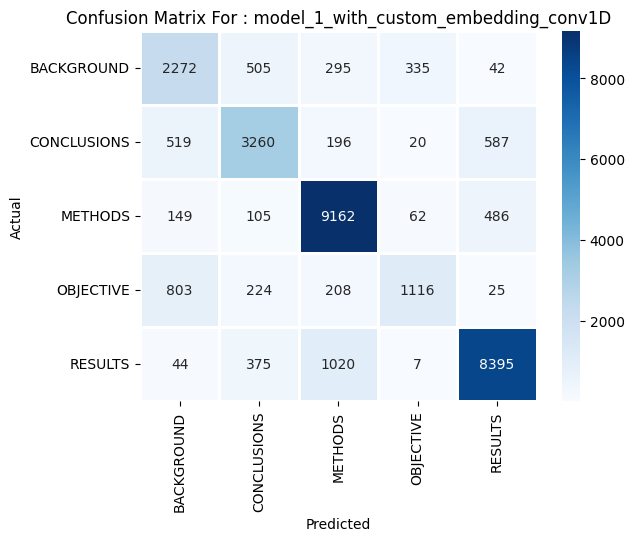

In [100]:
evaluate_model(val_labels_encoded, model_1_pred, "model_1_with_custom_embedding_conv1D")

# Model 2 (Feature Extraction Embedding)
- This paper originally used Glove embedding but we are here going to use universal sentence encoder using tensorflow hub

In [101]:
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False)

In [102]:
inputs = Input(shape=[], dtype=tf.dtypes.string)

In [103]:
x = embedding_layer(inputs)

In [104]:
x = Dense(128, activation="relu")(x)

In [105]:
outputs = Dense(5, activation="softmax")(x)

In [106]:
model_2 = tf.keras.Model(inputs, outputs)

In [107]:
model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [108]:
history_model_2 = model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    verbose=1,
    epochs=5,
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_steps=int(0.1*len(val_dataset)),
    callbacks=[create_tensorboard_callback("model_2_embedding_feature")]
)

Epoch 1/5
562/562 [==============================] - 15s 19ms/step - loss: 0.9198 - accuracy: 0.6505 - val_loss: 0.7962 - val_accuracy: 0.6912
Epoch 2/5
562/562 [==============================] - 8s 13ms/step - loss: 0.7691 - accuracy: 0.7013 - val_loss: 0.7542 - val_accuracy: 0.7055
Epoch 3/5
562/562 [==============================] - 11s 19ms/step - loss: 0.7536 - accuracy: 0.7106 - val_loss: 0.7385 - val_accuracy: 0.7141
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7201 - accuracy: 0.7226 - val_loss: 0.7113 - val_accuracy: 0.7267
Epoch 5/5
562/562 [==============================] - 10s 18ms/step - loss: 0.7287 - accuracy: 0.7195 - val_loss: 0.6904 - val_accuracy: 0.7350


In [109]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7004 - accuracy: 0.7343


[0.7004461884498596, 0.7342777848243713]

In [110]:
model_2_pred = model_2.predict(val_dataset)

945/945 [==============================] - 12s 13ms/step


In [111]:
model_2_pred = tf.argmax(model_2_pred, axis=-1).numpy()

In [112]:
model_2_pred

array([0, 0, 3, ..., 4, 4, 2])

              precision    recall  f1-score   support

           0       0.58      0.53      0.56      3449
           1       0.63      0.60      0.61      4582
           2       0.75      0.88      0.81      9964
           3       0.66      0.45      0.54      2376
           4       0.82      0.79      0.80      9841

    accuracy                           0.73     30212
   macro avg       0.69      0.65      0.66     30212
weighted avg       0.73      0.73      0.73     30212



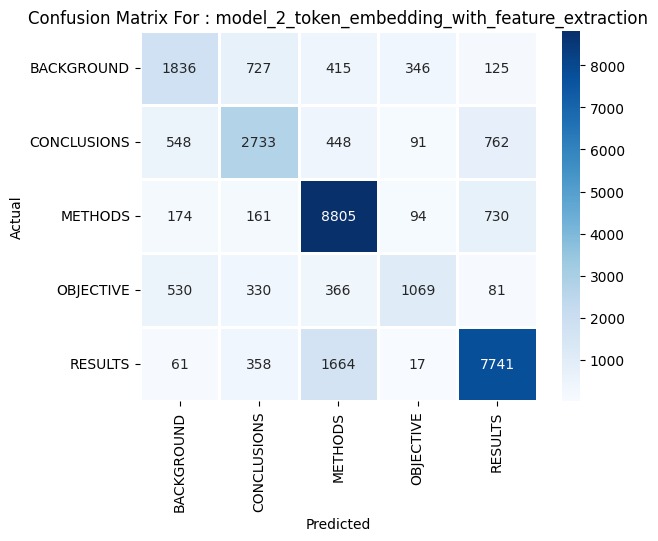

In [113]:
evaluate_model(val_labels_encoded, model_2_pred, "model_2_token_embedding_with_feature_extraction")

# Model 3 Conv1D with character level embedding
- The paper that we are implementing they used combination of character and word level embedding
- previouse we did token level embedding now we are going to try character level embedding
- So we need to format our data at character level

In [114]:
def split_chars(text):
  return " ".join(list(text))

In [115]:
train_chars = [split_chars(sentence) for sentence in train_sentences]

In [116]:
val_chars = [split_chars(sentence) for sentence in val_sentences]

In [117]:
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [118]:
# what's the average number of character
char_lens = [len(sentence) for sentence in train_sentences]

In [119]:
import numpy as np
mean_char_len = np.mean(char_lens)

In [120]:
mean_char_len

149.3662574983337

In [121]:
import matplotlib.pyplot as plt

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

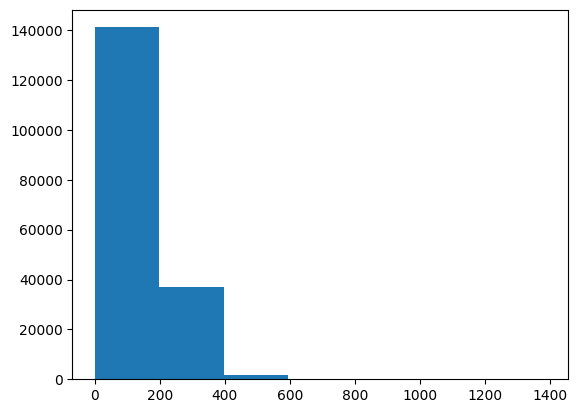

In [122]:
plt.hist(char_lens, bins=7)

In [123]:
# find out what character lenght covers 95% of
output_seq_char_len = int(np.percentile(char_lens, 95))

In [124]:
output_seq_char_len

290

In [125]:
# Get all keyboard characters

In [126]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [127]:
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [128]:
# Creating character lever token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and OOV take (out of vocab, '[UNK]')
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    name="char_vectorizer"
)

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()

In [ ]:
char_vectorizer(train_chars[0])

In [ ]:
char_embedding = Embedding(
    input_dim=len(char_vocab),
    output_dim=25,
    mask_zero=False,
)

In [ ]:
char_embedding(char_vectorizer(train_chars[0]))

In [ ]:
inputs = Input(shape=(1,), dtype=tf.dtypes.string)

In [ ]:
x = char_vectorizer(inputs)

In [ ]:
x = char_embedding(x)

In [ ]:
x = Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(x)

In [ ]:
x = GlobalAveragePooling1D()(x)

In [ ]:
outputs = Dense(5, activation="softmax", )(x)

In [ ]:
model_3 = tf.keras.Model(inputs, outputs)

In [ ]:
model_3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
train_chars_ = np.reshape(train_chars, (-1, 1))

In [ ]:
val_chars_ = np.reshape(val_chars, (-1, 1))

In [ ]:
test_chars = np.reshape(test_chars, (-1, 1))

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars_, train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars_, val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

In [ ]:
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_model_3 = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1*len(train_char_dataset)),
    validation_data=val_char_dataset,
    validation_steps=int(0.1*len(val_char_dataset)),
    epochs=5,
    verbose=1,
    callbacks=[create_tensorboard_callback("model_3_character_level_tokenization_and_embedding")]
)

Epoch 1/5
562/562 [==============================] - 8s 8ms/step - loss: 1.4589 - accuracy: 0.3557 - val_loss: 1.4036 - val_accuracy: 0.4126
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.3640 - accuracy: 0.4303 - val_loss: 1.3312 - val_accuracy: 0.4465
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 1.3244 - accuracy: 0.4528 - val_loss: 1.3137 - val_accuracy: 0.4445
Epoch 4/5
562/562 [==============================] - 4s 6ms/step - loss: 1.3023 - accuracy: 0.4596 - val_loss: 1.2963 - val_accuracy: 0.4641
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 1.2969 - accuracy: 0.4550 - val_loss: 1.2858 - val_accuracy: 0.4701


In [ ]:
model_3.evaluate(val_chars_, val_labels_one_hot)

945/945 [==============================] - 4s 4ms/step - loss: 1.2851 - accuracy: 0.4710


[1.2851126194000244, 0.47103798389434814]

In [ ]:
model_3_pred = model_3.predict(val_chars_)

945/945 [==============================] - 3s 3ms/step


In [ ]:
model_3_pred = tf.argmax(model_3_pred, axis=-1).numpy()

In [ ]:
model_3_pred

array([2, 4, 2, ..., 4, 4, 4])

              precision    recall  f1-score   support

           0       0.27      0.06      0.09      3449
           1       0.32      0.20      0.25      4582
           2       0.49      0.72      0.58      9964
           3       0.24      0.05      0.09      2376
           4       0.51      0.59      0.55      9841

    accuracy                           0.47     30212
   macro avg       0.37      0.32      0.31     30212
weighted avg       0.43      0.47      0.43     30212



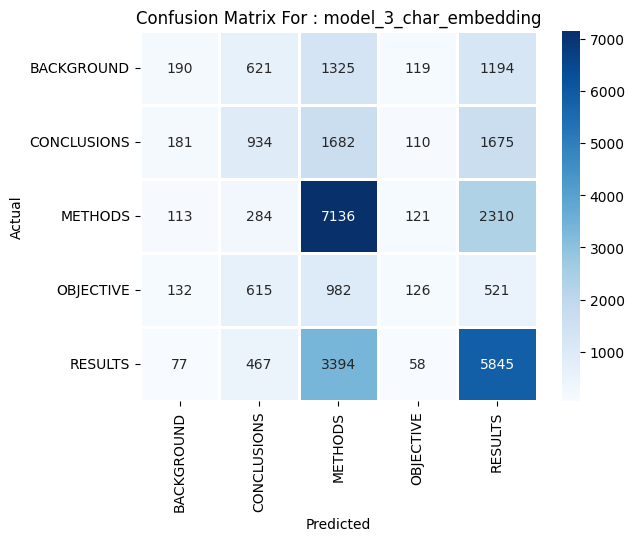

In [ ]:
evaluate_model(val_labels_encoded, model_3_pred, "model_3_char_embedding")

# Model 4 (Combine Pretrained Token embedding + Character embedding)
- create token-level embedding similar to model 1
- create character level embedding similar to model 3
- combine 1 and 2 with concetanate layer
- Build a series of output layers (based on section 4.2 of  https://arxiv.org/abs/1612.05251)

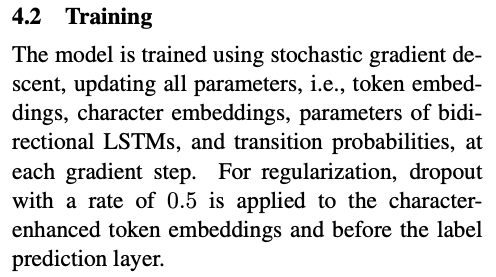


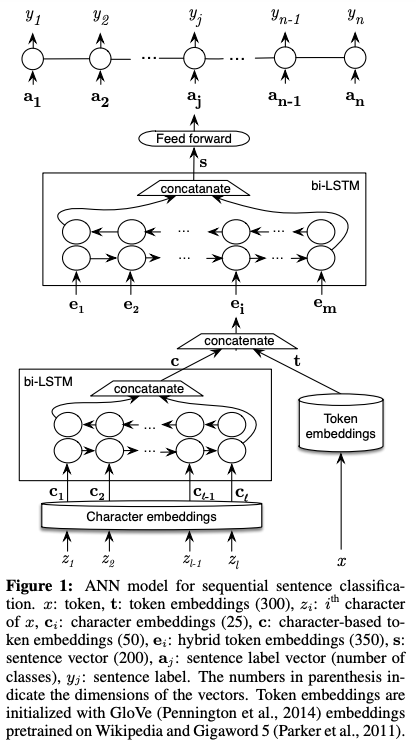

In [ ]:
# 1. Setup token inputs/model
token_inputs = Input(shape=[], dtype=tf.dtypes.string, name="token_input")
token_embedding = embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs)

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM
# 2. Setup char inputs/model
char_inputs = Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = Bidirectional(LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [ ]:
from tensorflow.keras.layers import Concatenate
# 3. concatenate token and char inputs
token_char_concat = Concatenate(name="token_char_hybrid")([
    token_model.output,
    char_model.output
])

In [ ]:
from tensorflow.keras.layers import Dropout
# 4. create output layer - adding in Dropout
combined_dropout = Dropout(0.5)(token_char_concat)
combined_dense = Dense(128, activation="relu")(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(5, activation="softmax")(final_dropout)

In [ ]:
# Creating model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embedding")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_4[0][0]']                
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['

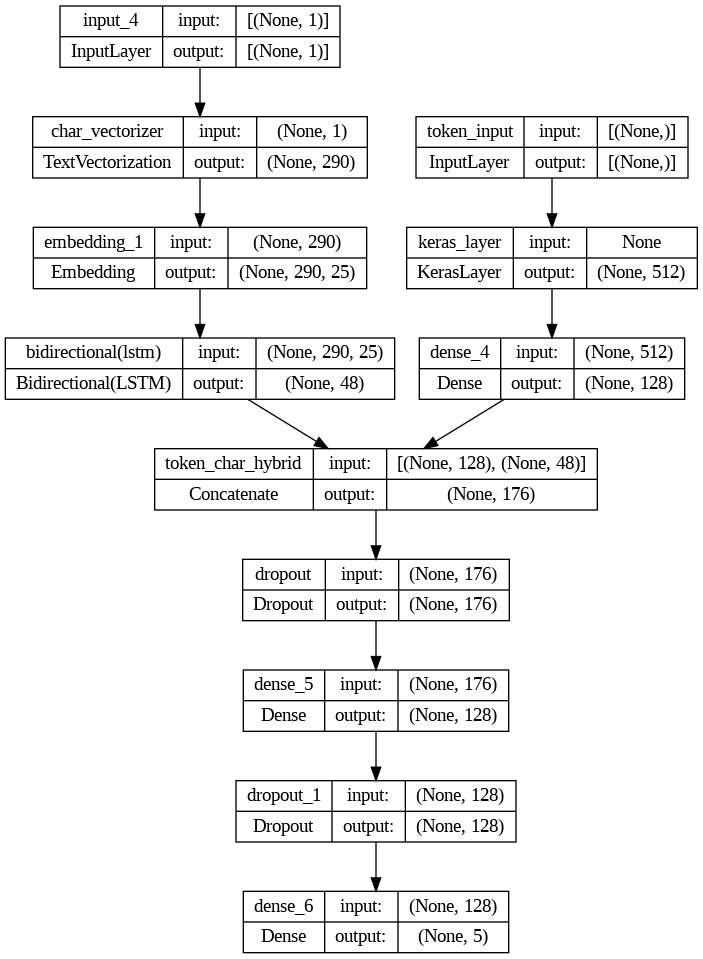

In [ ]:
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [ ]:
#compiling
model_4.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

## Creating Dataset

In [ ]:
# for train
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# for validation
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# for test
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
val_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Fitting model

In [ ]:
history_model_4 = model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_dataset)),
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1*len(val_char_token_dataset)),
    verbose=1,
    epochs=5,
    callbacks=[create_tensorboard_callback("model_4_with_token_and_character_embedding")]
)

Epoch 1/5
562/562 [==============================] - 221s 372ms/step - loss: 0.9810 - accuracy: 0.6041 - val_loss: 0.7816 - val_accuracy: 0.6985
Epoch 2/5
562/562 [==============================] - 204s 363ms/step - loss: 0.8042 - accuracy: 0.6862 - val_loss: 0.7254 - val_accuracy: 0.7217
Epoch 3/5
562/562 [==============================] - 209s 373ms/step - loss: 0.7758 - accuracy: 0.7042 - val_loss: 0.6990 - val_accuracy: 0.7354
Epoch 4/5
562/562 [==============================] - 207s 368ms/step - loss: 0.7478 - accuracy: 0.7189 - val_loss: 0.6751 - val_accuracy: 0.7460
Epoch 5/5
562/562 [==============================] - 209s 372ms/step - loss: 0.7526 - accuracy: 0.7127 - val_loss: 0.6612 - val_accuracy: 0.7497


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 73s 77ms/step - loss: 0.6680 - accuracy: 0.7448


[0.6679862141609192, 0.7448033690452576]

In [ ]:
model_4_pred = model_4.predict(val_char_token_dataset)

945/945 [==============================] - 75s 76ms/step


In [ ]:
model_4_pred = tf.argmax(model_4_pred, axis=-1).numpy()

              precision    recall  f1-score   support

           0       0.58      0.54      0.56      3449
           1       0.66      0.58      0.62      4582
           2       0.76      0.90      0.82      9964
           3       0.70      0.52      0.60      2376
           4       0.83      0.79      0.81      9841

    accuracy                           0.74     30212
   macro avg       0.71      0.66      0.68     30212
weighted avg       0.74      0.74      0.74     30212



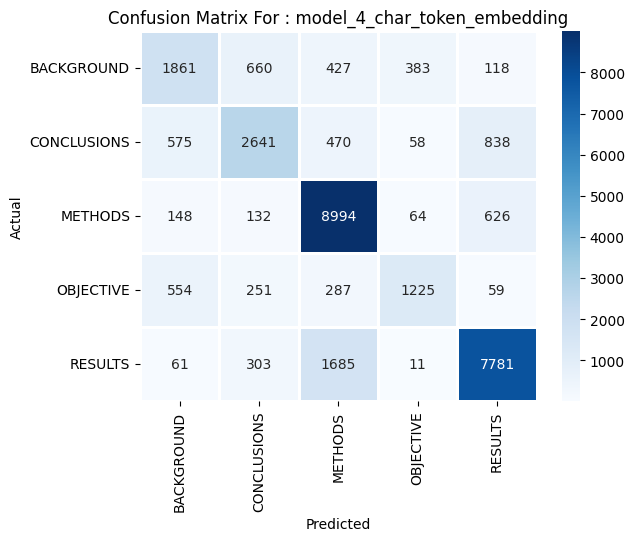

In [ ]:
evaluate_model(val_labels_encoded, model_4_pred, "model_4_char_token_embedding")

# Model 5 (token + char + positional embedding)
- As position of a sentence in abstract matter
- for example earlier one are most likely to belong to objective and last one are most likely to belong to conclusion
- so now we will try to include positioal embedding too as describe in the paper
- Sequnce label layer
- So here we are going to use our **line number** and **total lines** to create positional embedding **(feature engineering)**
- **Note :** any engineered feature used to train a model need to be available at test time

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Creating positional embedding for line numbers

In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: >

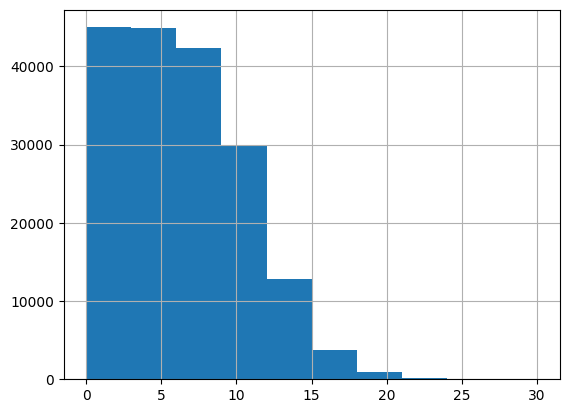

In [ ]:
train_df["line_number"].hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_line_numbers_one_hot[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# creating positional embedding for toal lines

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: >

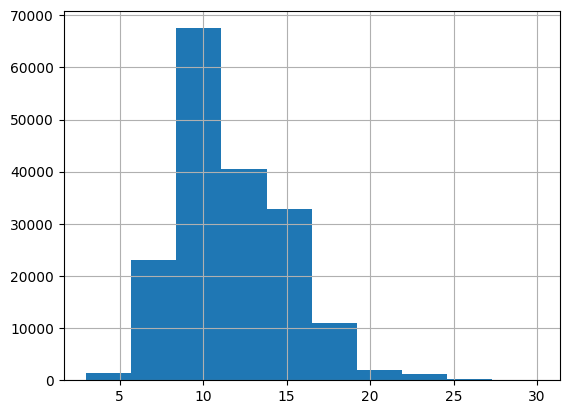

In [ ]:
train_df["total_lines"].hist()

In [ ]:
np.percentile(train_df["total_lines"].to_numpy(), 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

## Creating a tribrid embedding model
1. Creat a token level model
2. Creat a char level model
3. Create a model for "line_number" feature
4. Creat a model for "total_lines" feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine 3, 4, 5 using tf.keras.layers.Concatenate
7. Create a output layer to accept the tribrid embeeding and output label probabilities

In [ ]:
# 1. Token inputs
token_inputs = Input(shape=[], dtype=tf.dtypes.string, name="token_inputs")
token_embeddings = embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

In [ ]:
# 2. char inputs
char_inputs = Input(shape=(1,), dtype=tf.dtypes.string, name="char_inputs")
char_vectorized = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectorized)
char_bi_lstm = Bidirectional(LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [ ]:
# 3. line number model
line_number_inputs = Input(shape=(15,), dtype=tf.dtypes.float32, name="line_number_input")
x = Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

In [ ]:
# 4. total lines model
total_lines_inputs = Input(shape=(20,), dtype=tf.dtypes.float32, name="total_lines_input")
y = Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

In [ ]:
# 5. Combine token and char embeddings in hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])
z = Dense(256, activation="relu")(combined_embeddings)
z = Dropout(0.5)(z)

In [ ]:
# 6. Combine positional embedding with token char combined embedding
tribrid_embedding = tf.keras.layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output, total_lines_model.output, z])

In [ ]:
# 7. Create output layer
output_layer = Dense(5, activation="softmax", name="output_layer")(tribrid_embedding)

In [ ]:
model_5 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
                         outputs=output_layer, name="tribrid_model")

In [ ]:
# summary of model 5
model_5.summary()

Model: "tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_inputs[0][0]'

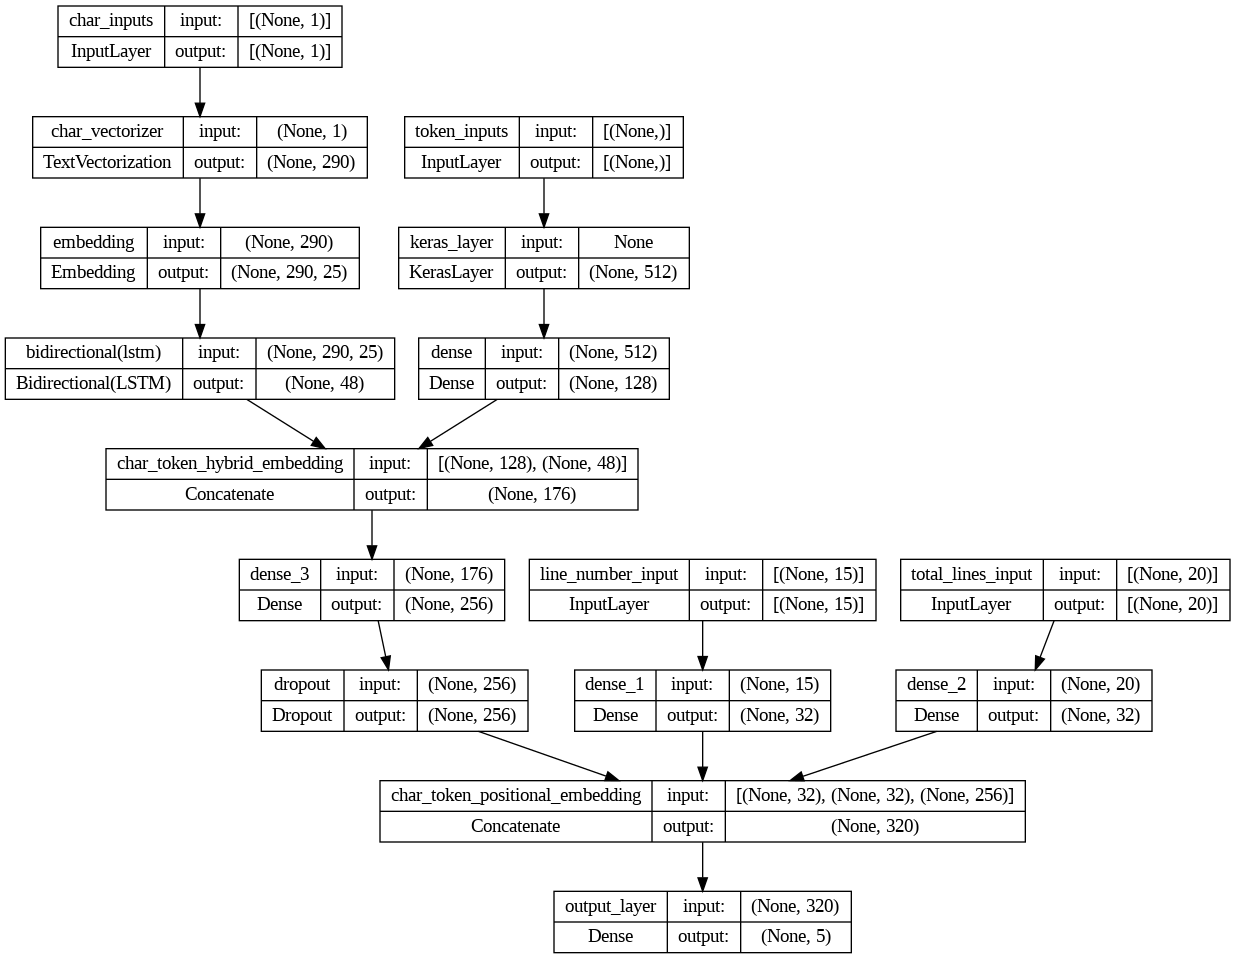

In [ ]:
............# Visualizing Model
tf.keras.uti00ls.plot_model(model_5, "/content/drive/MyDrive/Skimlit Project/model_5.png", show_shapes=True)

In [ ]:
# compiling token, char, and poisitonal embedding(feature engineering) model

In [ ]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

label smoothing:
Label smoothing ek regularization technique hai jo model ki overfitting ko kam karne aur generalization ko improve karne ke liye istemal hota hai.

Jab aap model ko train karte hain, toh categorical cross entropy loss function categorical classification tasks mein istemal hota hai. Is loss function mein, har ek target class ke liye ek one-hot encoded vector hota hai jis mein sirf target class 1 hota hai aur baqi classes mein 0. Label smoothing ka mtlab hota hai ke target class ko 1 se kam weight diya jata hai aur baqi classes ko bhi thora sa weight diya jata hai.
0


## Creating tribrid embedding dataset

In [ ]:
train_char_token_position_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))
train_char_token_position_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_position_dataset = tf.data.Dataset.zip((train_char_token_position_data, train_char_token_position_label))
train_char_token_position_dataset = train_char_token_position_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_position_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars))
val_char_token_position_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_position_dataset = tf.data.Dataset.zip((val_char_token_position_data, val_char_token_position_label))
val_char_token_position_dataset = val_char_token_position_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_char_token_position_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_char_token_position_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
test_char_token_position_dataset = tf.data.Dataset.zip((test_char_token_position_data, test_char_token_position_label))
test_char_token_position_dataset = test_char_token_position_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## fitting our tribrid model

In [ ]:
history_model_5 = model_5.fit(
    train_char_token_position_dataset,
    validation_data=val_char_token_position_dataset,
    epochs=5,
    verbose=1,
    callbacks=[create_tensorboard_callback("model_5_char_token_poisition_embedding")],
    steps_per_epoch=int(0.1*len(train_char_token_position_dataset)),
    validation_steps=int(0.1*len(val_char_token_position_dataset))
)

Epoch 1/5
562/562 [==============================] - 48s 65ms/step - loss: 0.9096 - accuracy: 0.8563 - val_loss: 0.9169 - val_accuracy: 0.8438
Epoch 2/5
562/562 [==============================] - 34s 61ms/step - loss: 0.8987 - accuracy: 0.8625 - val_loss: 0.9133 - val_accuracy: 0.8474
Epoch 3/5
562/562 [==============================] - 31s 55ms/step - loss: 0.9158 - accuracy: 0.8480 - val_loss: 0.9172 - val_accuracy: 0.8431
Epoch 4/5
562/562 [==============================] - 37s 66ms/step - loss: 0.9096 - accuracy: 0.8548 - val_loss: 0.9137 - val_accuracy: 0.8434
Epoch 5/5
562/562 [==============================] - 32s 58ms/step - loss: 0.9134 - accuracy: 0.8524 - val_loss: 0.9095 - val_accuracy: 0.8481


In [ ]:
model_5.evaluate(val_char_token_position_dataset)

945/945 [==============================] - 27s 29ms/step - loss: 0.9218 - accuracy: 0.8434


[0.9218016266822815, 0.8433734774589539]

In [ ]:
model_5_pred = model_5.predict(val_char_token_position_dataset)

945/945 [==============================] - 43s 35ms/step


In [ ]:
model_5_pred = tf.argmax(model_5_pred, axis=-1).numpy()

              precision    recall  f1-score   support

           0       0.70      0.82      0.76      3449
           1       0.87      0.84      0.85      4582
           2       0.85      0.94      0.89      9964
           3       0.82      0.47      0.60      2376
           4       0.90      0.85      0.87      9841

    accuracy                           0.84     30212
   macro avg       0.83      0.78      0.79     30212
weighted avg       0.85      0.84      0.84     30212



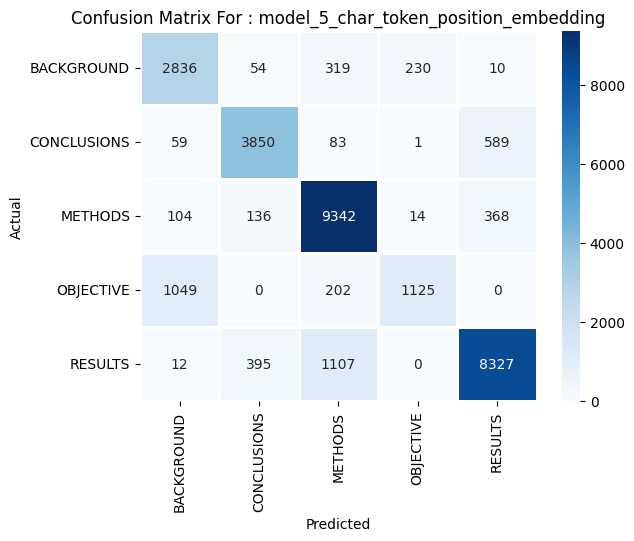

In [ ]:
evaluate_model(val_labels_encoded, model_5_pred, "model_5_char_token_position_embedding")

# Saving and Loading Our Best Model
- It seems our model 5 worked best with 84% accuracy when trained on 10% data and validated on 10% data



In [ ]:
model_5.save("my_model_5.h5")

NotImplementedError: ignored